In [1]:
import re
import os
import sys
import math
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from functools import partial

from matplotlib.colors import LogNorm

from scipy          import stats
from scipy.optimize import curve_fit

In [2]:
# Define the function for a single Gaussian peak
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * stddev**2))

# Define the function for multiple Gaussian peaks
def multi_gaussian(x, *params):
    n_peaks = len(params) // 3
    y = np.zeros_like(x)
    for i in range(n_peaks):
        amplitude = params[i * 3]
        mean = params[i * 3 + 1]
        stddev = params[i * 3 + 2]
        y += gaussian(x, amplitude, mean, stddev)
    return y

def shift_to_bin_centers(x):
    """
    Return bin centers, given bin lower edges.
    """
    return x[:-1] + np.diff(x) * 0.5

def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

def plot_linear_fit(y, yerr):
    x    = np.arange(len(y))+1
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    line = slope*x + intercept
    
    fig = plt.figure(figsize=(8,5))
    plt.errorbar(x, y, yerr=yerr, marker='_', markersize=5, linestyle='', c='k', label=f'Measured gain values')
    plt.plot(x, line, color='r', alpha=0.7, label=f'Fit: y = x*{round(slope, 2)} - {round(np.abs(intercept), 2)}, \n     R$^2$ = {truncate(r_value, 2)}')
    
    plt.xlabel('Peak number')
    plt.ylabel('Mu from fit (ADCs)')
    plt.legend(fontsize=14, loc='upper left')
    plt.show()
    return slope

def fit_spectrum_and_plot(data, channel=7, initial_guess=[1000, 100, 20], bins=150, rng=(100,1500), num_peaks_fit=4):
    
    plt.figure(figsize=(7, 5))
    y, x, _ = plt.hist(data, bins=bins, range=rng, log=False, alpha=0.6)

    popt, pcov = curve_fit(multi_gaussian, shift_to_bin_centers(x), y, p0=initial_guess)
    
    plt.plot(x, multi_gaussian(x, *popt), 'r--', label='Fit')
    plt.xlabel('Amplitude (ADCs)',      fontsize=15)
    plt.ylabel('Entries/bin',           fontsize=15)
    plt.title(f"Spectrum for channel {channel} (height of the peaks)", fontsize=15)
    plt.tight_layout()
    plt.show()
    
    perr = np.sqrt(np.diag(pcov))
    
    all_means     = np.array([popt[i*3+1] for i in range(len(popt)//3)])
    all_means_err = np.array([perr[i*3+1] for i in range(len(perr)//3)])
    
    return plot_linear_fit(all_means[:num_peaks_fit], all_means_err[:num_peaks_fit])

In [3]:
evts_path   = '/Users/romoluque_c/LEGEND/BACON/data_npz/'
trigger_chs = [9, 10, 11]

height_peaks_deconv_ch_trigg_all_runs = {}

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

files        = os.listdir(evts_path)
filt_files   = [file for file in files if file.startswith("BACoN_hits_and_times_thr50_md50_run-")]
sorted_files = sorted(filt_files, key=extract_date_and_number)

for filename in sorted_files:
    my_file    = evts_path+filename
    d          = np.load(my_file, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
        
    if date not in height_peaks_deconv_ch_trigg_all_runs:
        print(date)
        height_peaks_deconv_ch_trigg_all_runs[date] = d['height_peaks_deconv_ch_trigg_dict'].item()
        continue
    
    for ch in trigger_chs:
        height_peaks_deconv_ch_trigg_all_runs[date][ch] = np.concatenate((height_peaks_deconv_ch_trigg_all_runs[date][ch], d['height_peaks_deconv_ch_trigg_dict'].item()[ch]))

01_01_2024
01_02_2024
01_04_2024
01_05_2024
01_07_2024
01_09_2024
01_10_2024
01_12_2024
01_15_2024
11_20_2023
11_21_2023
11_23_2023
11_24_2023
11_25_2023
11_26_2023
11_28_2023
11_29_2023
11_30_2023
12_20_2023
12_21_2023
12_24_2023
12_26_2023
12_28_2023
12_30_2023


In [4]:
height_peaks_deconv_ch_trigg_all_runs_concat = {}
            
for i,date in enumerate(height_peaks_deconv_ch_trigg_all_runs.keys()):
    height_peaks_deconv_ch_trigg_all_runs_concat[date] = {}
    for ch in trigger_chs:
        height_peaks_deconv_ch_trigg_all_runs_concat[date][ch] = np.concatenate((height_peaks_deconv_ch_trigg_all_runs[date][ch]))        

In [5]:
dates = [['11_20_2023'],
         ['11_21_2023','11_23_2023','11_24_2023','11_25_2023','11_26_2023','11_28_2023','11_29_2023','11_30_2023'],
         ['12_20_2023','12_21_2023','12_24_2023','12_26_2023','12_28_2023','12_30_2023','01_01_2024','01_02_2024','01_04_2024','01_05_2024','01_07_2024', '01_09_2024','01_10_2024','01_12_2024','01_15_2024']] #['01_09_2024','01_10_2024','01_12_2024','01_15_2024']]

periods = ['11_20_2023', '11_21_2023-11_30_2023', '12_20_2023-01_15_2024']

In [6]:
height_peaks_deconv_ch_trigg_all_runs_concat_dates0 = {ch: np.concatenate([height_peaks_deconv_ch_trigg_all_runs_concat[date][ch] for date in dates[0]]) for ch in trigger_chs}
height_peaks_deconv_ch_trigg_all_runs_concat_dates1 = {ch: np.concatenate([height_peaks_deconv_ch_trigg_all_runs_concat[date][ch] for date in dates[1]]) for ch in trigger_chs}
height_peaks_deconv_ch_trigg_all_runs_concat_dates2 = {ch: np.concatenate([height_peaks_deconv_ch_trigg_all_runs_concat[date][ch] for date in dates[2]]) for ch in trigger_chs}
#height_peaks_deconv_ch_trigg_all_runs_concat_dates3 = {ch: np.concatenate([height_peaks_deconv_ch_trigg_all_runs_concat[date][ch] for date in dates[3]]) for ch in trigger_chs}

all_heights_deconv = [height_peaks_deconv_ch_trigg_all_runs_concat_dates0, height_peaks_deconv_ch_trigg_all_runs_concat_dates1, height_peaks_deconv_ch_trigg_all_runs_concat_dates2]

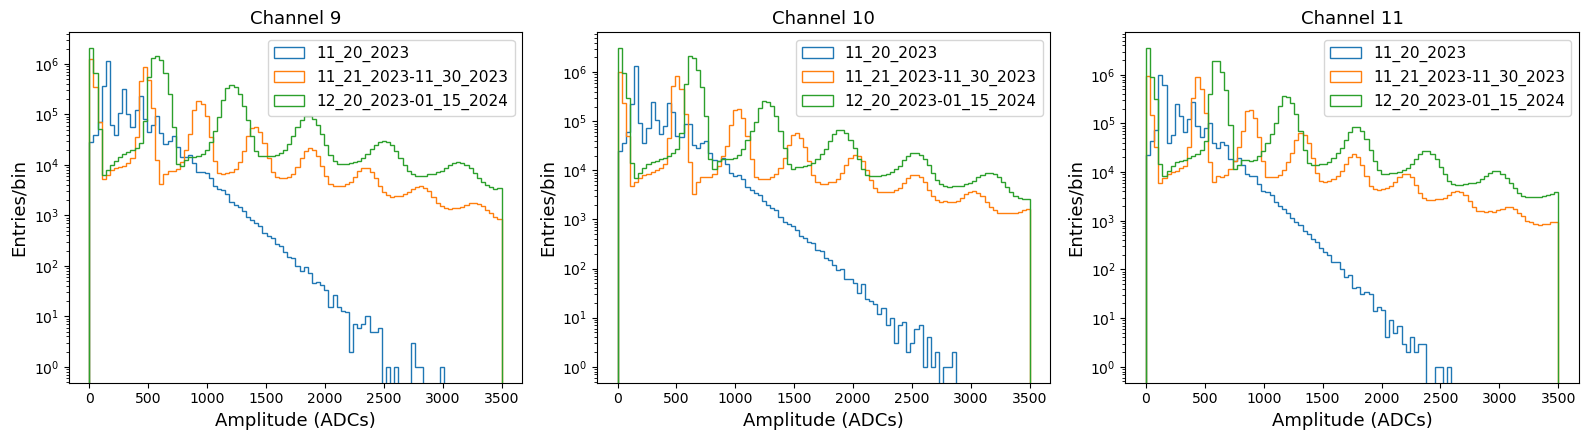

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4.5))
for k, (ch, group_dates) in enumerate(zip(trigger_chs, dates)):
    for data, per in zip(all_heights_deconv, periods):
        i = int(k/3)
        j = k%3
        axs[j].hist(data[ch], bins=100, range=(0,3500), log=True, label=f'{per}', histtype='step')
        axs[j].set_xlabel('Amplitude (ADCs)', fontsize=13)
        axs[j].set_ylabel('Entries/bin',      fontsize=13)
        axs[j].set_title(f"Channel {ch}",     fontsize=13)
        axs[j].legend(fontsize=11)
plt.tight_layout()
plt.show()

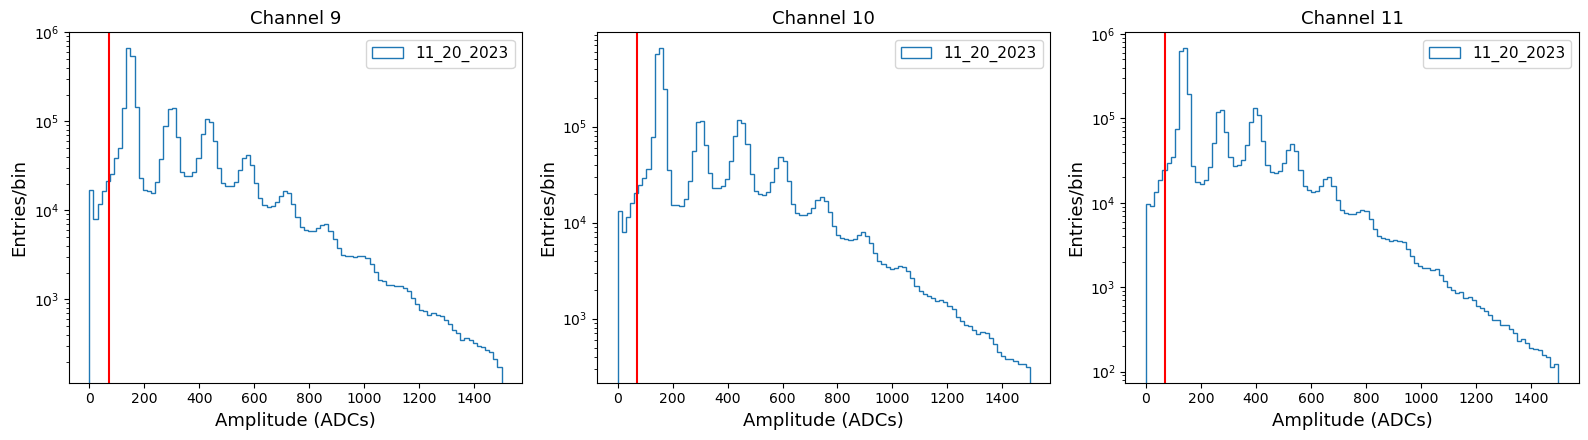

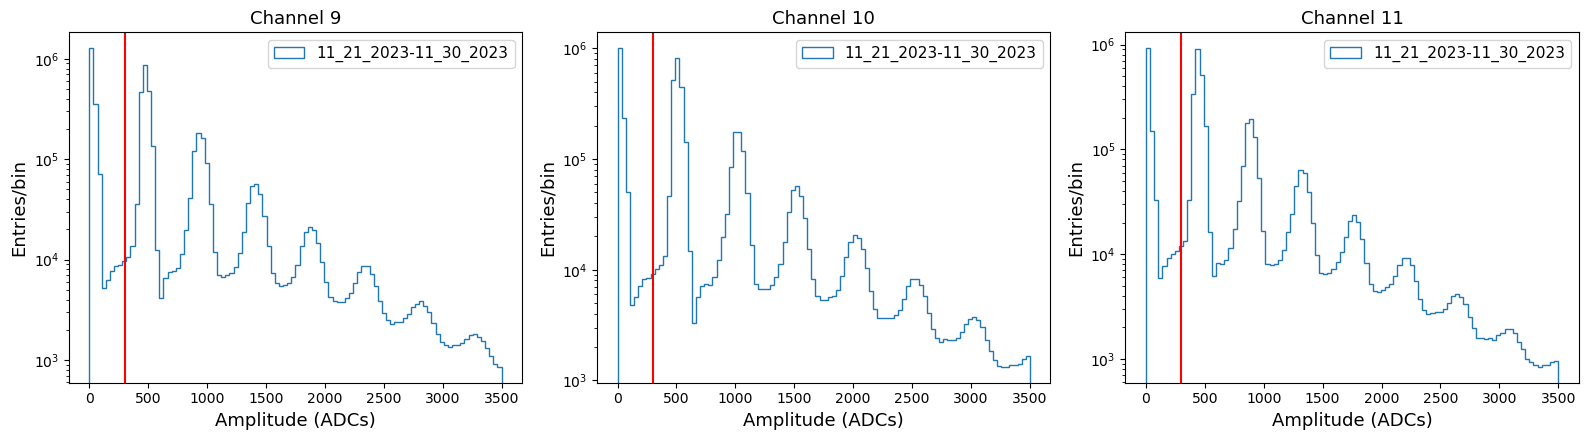

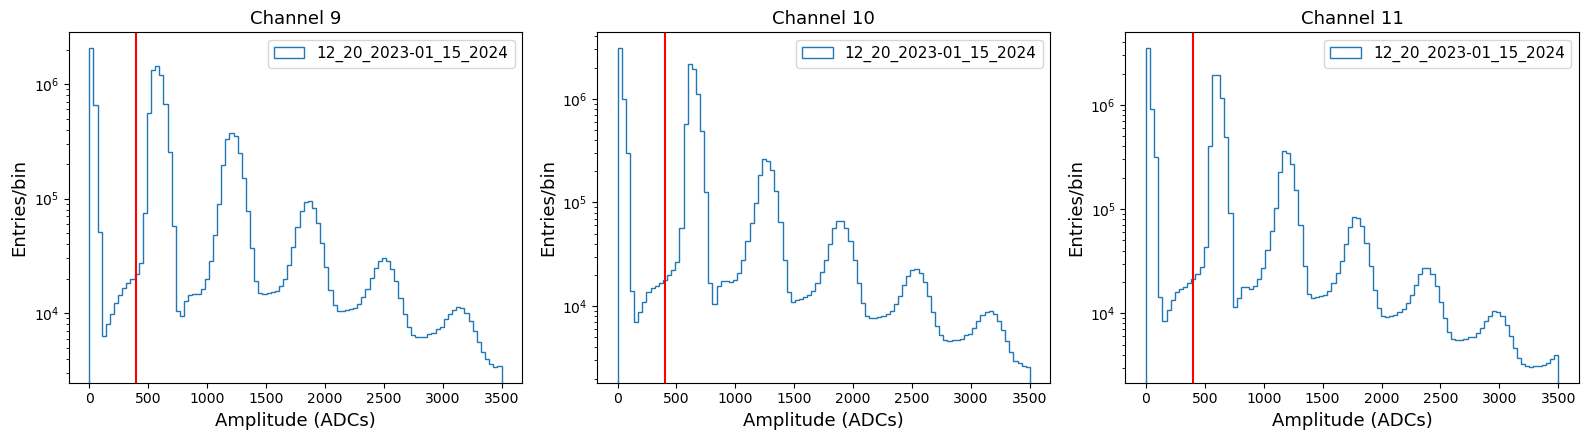

In [8]:
for data, per, rg, thr in zip(all_heights_deconv, periods, [(0,1500), (0,3500), (0,3500)], [70, 300, 400]):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4.5))
    for k, (ch, group_dates) in enumerate(zip(trigger_chs, dates)):
        i = int(k/3)
        j = k%3
        axs[j].hist(data[ch], bins=100, range=rg, log=True, label=f'{per}', histtype='step')
        axs[j].axvline(x=thr, color='r')
        axs[j].set_xlabel('Amplitude (ADCs)', fontsize=13)
        axs[j].set_ylabel('Entries/bin',      fontsize=13)
        axs[j].set_title(f"Channel {ch}",     fontsize=13)
        axs[j].legend(fontsize=11)
    plt.tight_layout()
    plt.show()

In [9]:
initial_guess_trigger_ch_increase1 = { 9: [150000, 180, 20, 70000, 330, 25, 50000, 460, 30, 20000, 600, 40],
                                      10: [125000, 180, 20, 50000, 330, 25, 50000, 475, 30, 20000, 620, 40],
                                      11: [140000, 165, 20, 60000, 300, 25, 60000, 425, 30, 20000, 555, 40]}

initial_guess_trigger_ch_increase2 = { 9: [600000, 480, 50, 100000,  950, 60, 40000, 1410, 70, 20000, 1880, 80],
                                      10: [600000, 510, 50, 120000, 1020, 60, 30000, 1520, 70, 13000, 2030, 80],
                                      11: [600000, 450, 50, 130000,  880, 60, 40000, 1330, 70, 15000, 1770, 80]}


initial_guess_trigger_ch_increase3 = { 9: [ 900000, 570, 50, 250000, 1220, 60, 50000, 1850, 70, 20000, 2500, 80],
                                      10: [1500000, 645, 50, 200000, 1270, 60, 40000, 1890, 70, 15000, 2520, 80],
                                      11: [1400000, 620, 50, 240000, 1200, 60, 50000, 1800, 70, 18000, 2380, 80]}


initial_guess_trigger_ch = [initial_guess_trigger_ch_increase1, initial_guess_trigger_ch_increase2, initial_guess_trigger_ch_increase3]

ranges = [(100,900), (300,3500), (300,3500)]

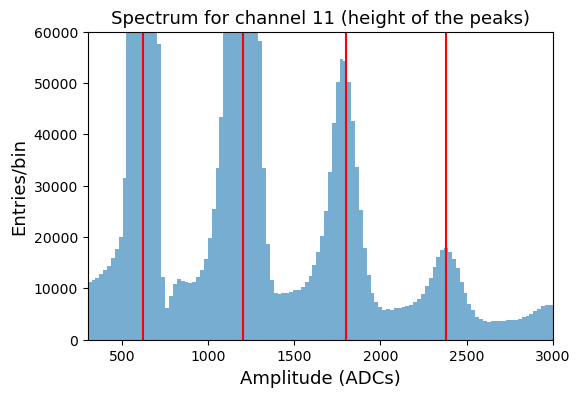

In [10]:
sel_channel = 11
sel_period  = 2
plt.figure(figsize=(6, 4))
y, x, _ = plt.hist(all_heights_deconv[sel_period][sel_channel], bins=120, range=(300,3000), log=False, alpha=0.6)
plt.axvline(x=620, color='r')
plt.axvline(x=1200, color='r')
plt.axvline(x=1800, color='r')
plt.axvline(x=2380, color='r')
plt.xlabel('Amplitude (ADCs)',      fontsize=13)
plt.ylabel('Entries/bin',           fontsize=13)
plt.title(f"Spectrum for channel {sel_channel} (height of the peaks)", fontsize=13)
plt.xlim(300, 3000)
plt.ylim(0, 60000)
plt.show()

-------------------------------
Channel 0, date = 12_30_2023
-------------------------------


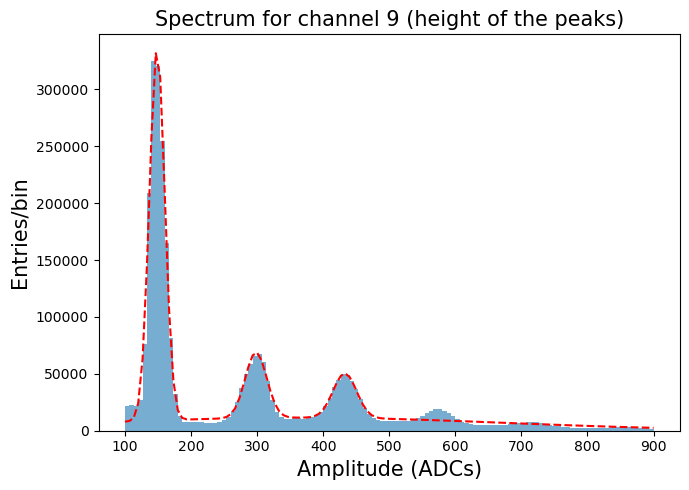

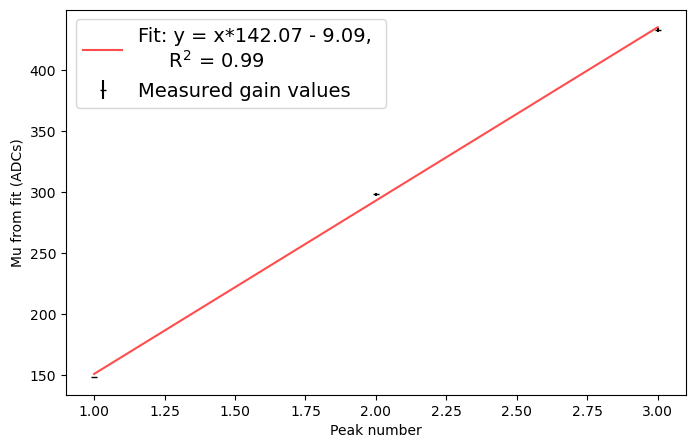

-------------------------------
Channel 1, date = 12_30_2023
-------------------------------


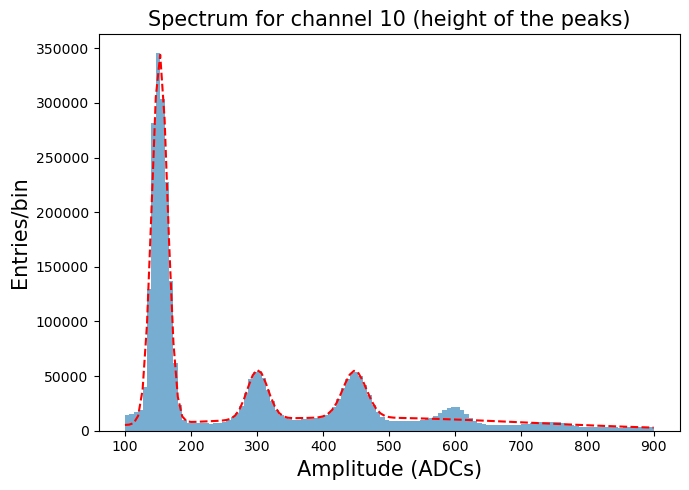

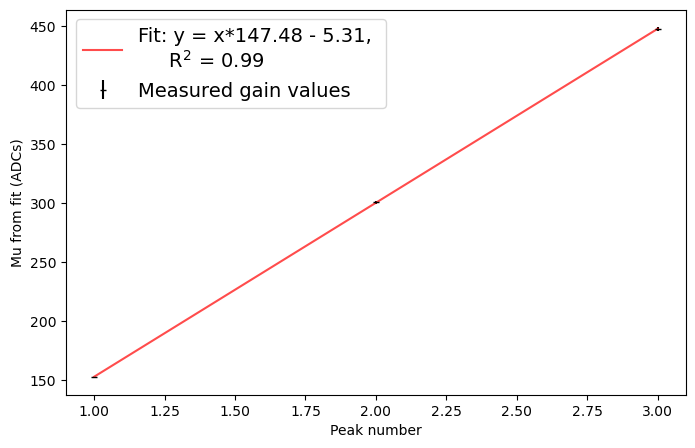

-------------------------------
Channel 2, date = 12_30_2023
-------------------------------


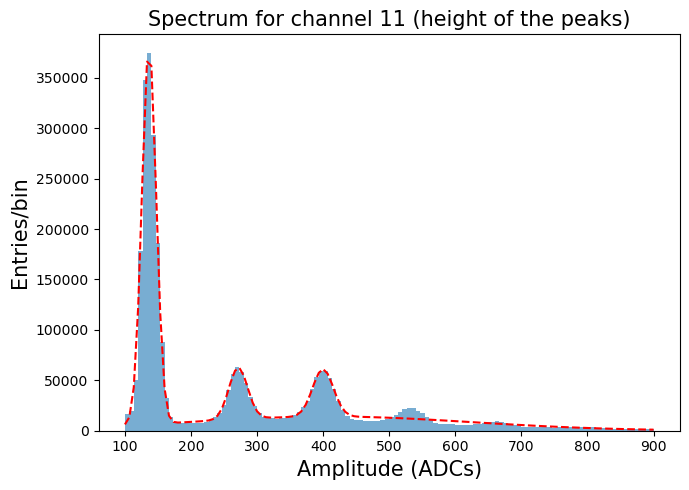

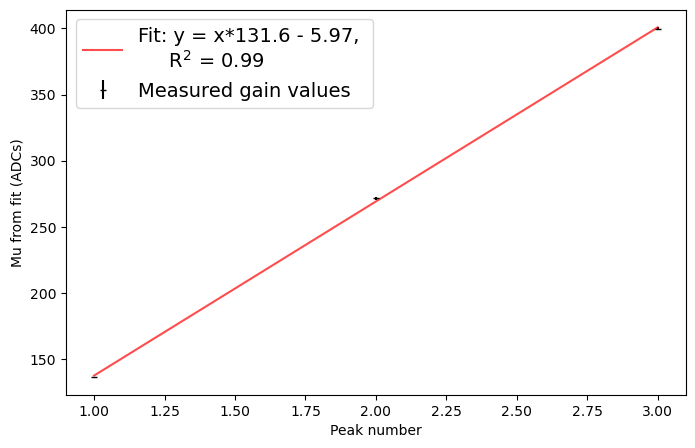

-------------------------------
Channel 0, date = 12_30_2023
-------------------------------


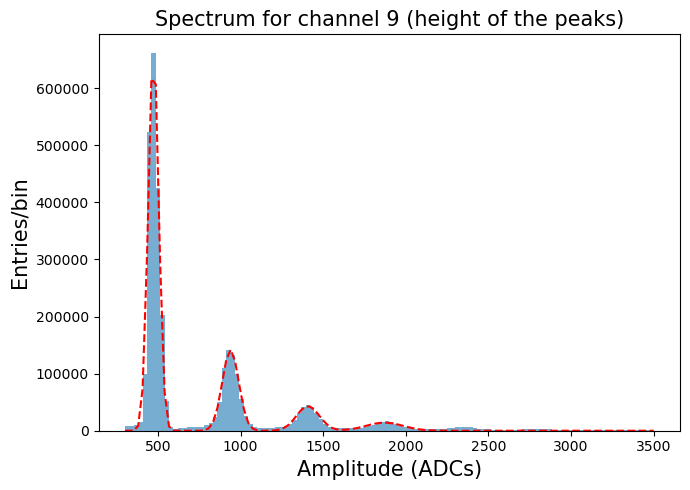

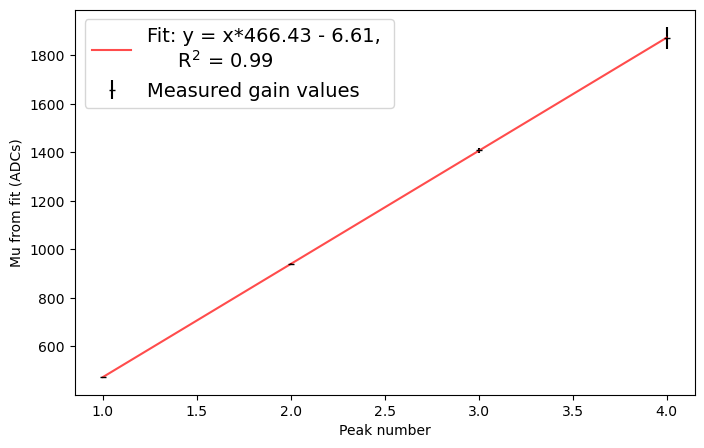

-------------------------------
Channel 1, date = 12_30_2023
-------------------------------


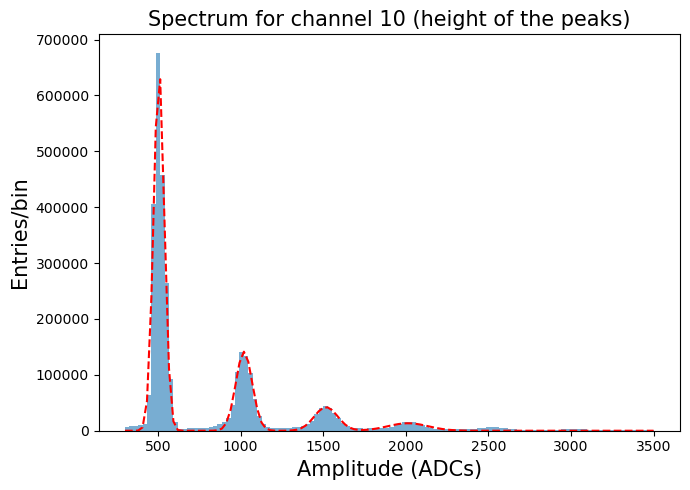

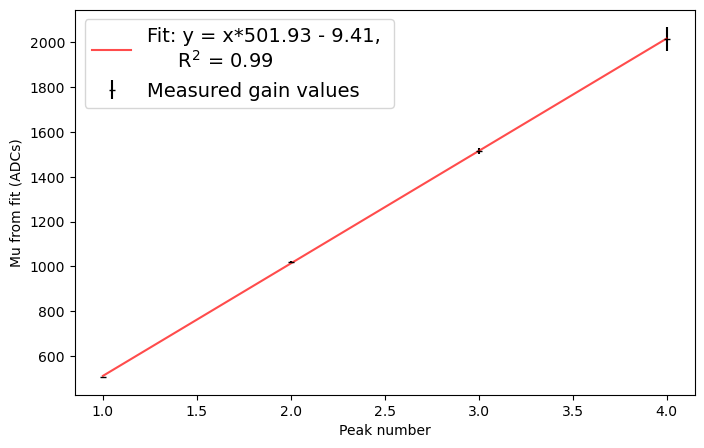

-------------------------------
Channel 2, date = 12_30_2023
-------------------------------


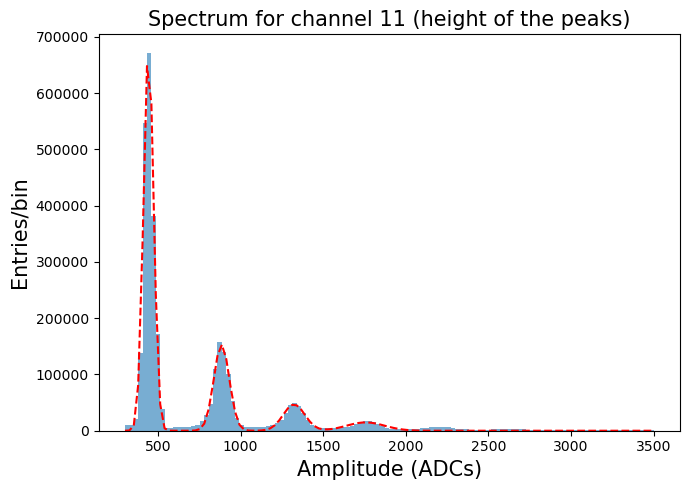

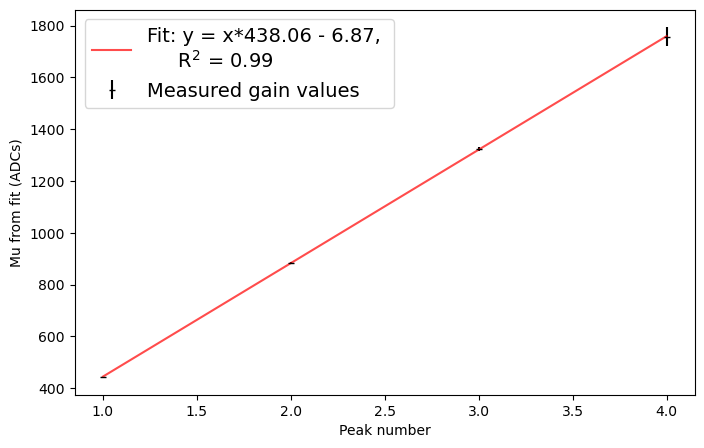

-------------------------------
Channel 0, date = 12_30_2023
-------------------------------


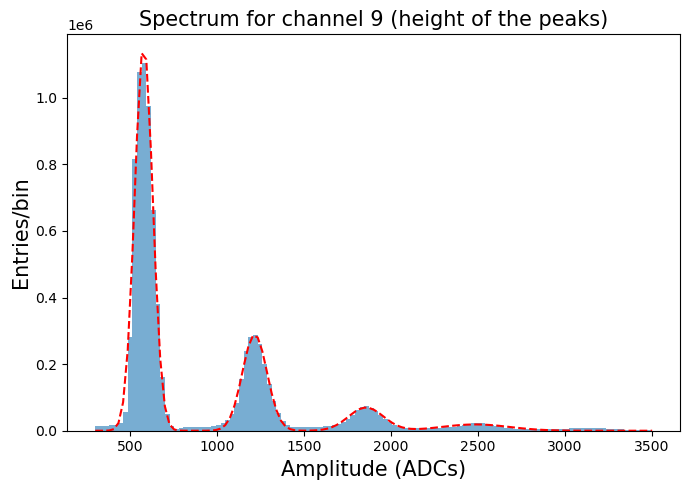

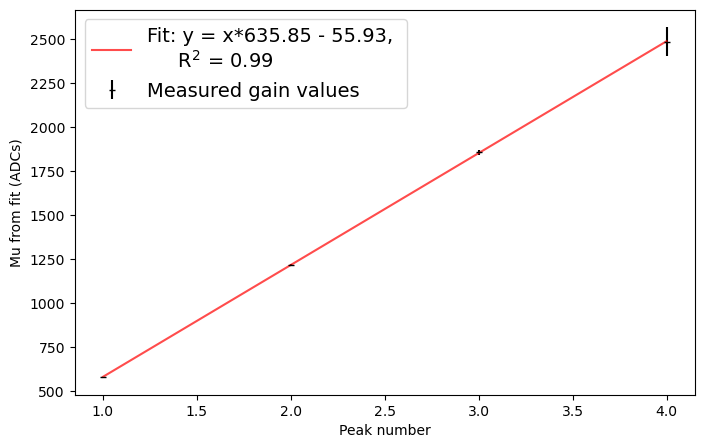

-------------------------------
Channel 1, date = 12_30_2023
-------------------------------


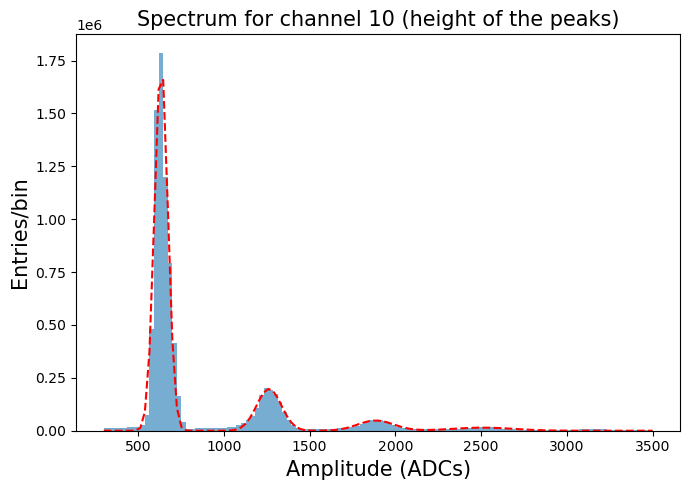

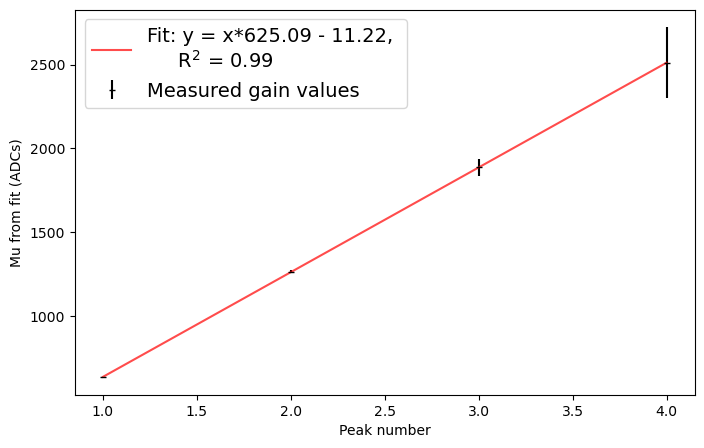

-------------------------------
Channel 2, date = 12_30_2023
-------------------------------


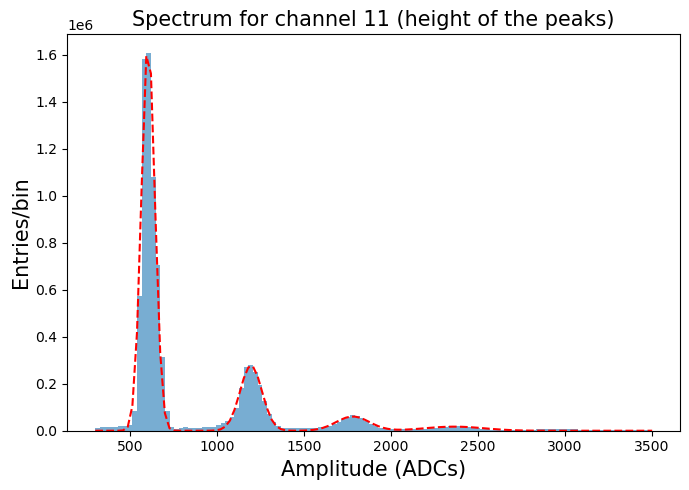

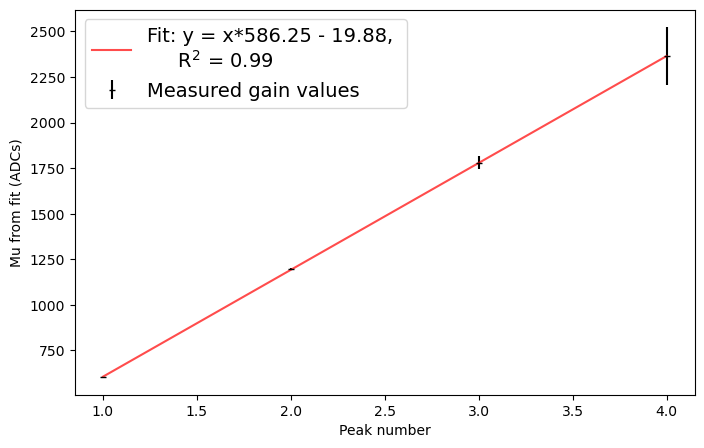

In [11]:
slopes_all_dates_trigger_SiPMs = {}

for period, data, ivals, rg, nfit_peaks in zip(periods, all_heights_deconv, initial_guess_trigger_ch, ranges, [3, 4, 4]):
    slope_ch = []
    for k in range(3):
        try:
            print('-------------------------------')
            print(f'Channel {k}, date = {date}')
            print('-------------------------------')
            slope = fit_spectrum_and_plot(data[k+9], channel=k+9, initial_guess=ivals[k+9], bins=120, rng=rg, num_peaks_fit=nfit_peaks)
            slope_ch.append(slope)
        except RuntimeError:
            slope_ch.append(0)
            continue
        
    slopes_all_dates_trigger_SiPMs[period] = np.array(slope_ch)

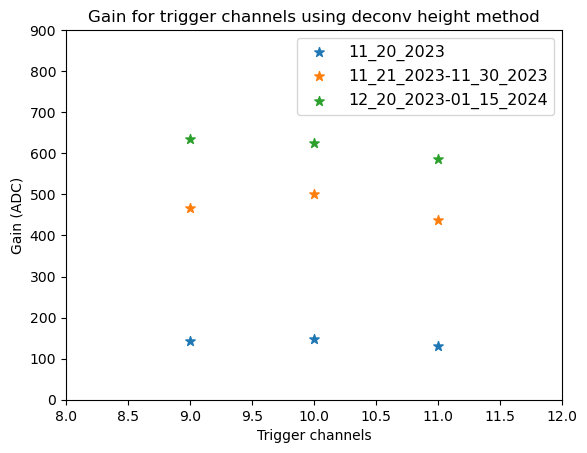

In [12]:
for sel_date in slopes_all_dates_trigger_SiPMs.keys():
    plt.scatter(trigger_chs, slopes_all_dates_trigger_SiPMs[sel_date], marker='*', s=50, label=f'{sel_date}')
plt.ylim(0, 900)
plt.xlim(8, 12)
plt.title('Gain for trigger channels using deconv height method')
plt.xlabel('Trigger channels')
plt.ylabel('Gain (ADC)')
plt.legend(fontsize=11.5)
plt.show()

## Once I have the gains for each period, I have to calibrate the spectrum for each case to transform into photoelectrons

### The thr for each period is different because the gain of the sensors vary

In [13]:
sum_peaks_above_thr_all_runs = {}
for i, (_, thr) in enumerate(zip(periods, [70, 300, 400])):
    for sel_date in height_peaks_deconv_ch_trigg_all_runs.keys():
        if sel_date in dates[i]:
            print(sel_date)
            sum_peaks_above_thr_all_runs[sel_date] = {ch: [np.sum(el[np.where(el>thr)[0]]) for el in height_peaks_deconv_ch_trigg_all_runs[sel_date][ch]] for ch in trigger_chs}

11_20_2023
11_21_2023
11_23_2023
11_24_2023
11_25_2023
11_26_2023
11_28_2023
11_29_2023
11_30_2023
01_01_2024
01_02_2024
01_04_2024
01_05_2024
01_07_2024
01_09_2024
01_10_2024
01_12_2024
01_15_2024
12_20_2023
12_21_2023
12_24_2023
12_26_2023
12_28_2023
12_30_2023


In [14]:
sum_peaks_above_thr_all_runs;

In [16]:
sum_3_chs_thr_all_runs_dict = {}
for k, ch in enumerate(trigger_chs):
    sum_3_chs_thr_all_runs_list = []
    for i,per in enumerate(periods):
        for sel_date in sum_peaks_above_thr_all_runs.keys():
            if sel_date in dates[i]:
                sum_3_chs_thr_all_runs_list.append(sum_peaks_above_thr_all_runs[sel_date][ch]/slopes_all_dates_trigger_SiPMs[per][k])
    sum_3_chs_thr_all_runs_dict[k] = np.concatenate(sum_3_chs_thr_all_runs_list)

sum_3_chs_thr_all_runs = np.sum(np.array([vals for vals in sum_3_chs_thr_all_runs_dict.values()]), axis=0)

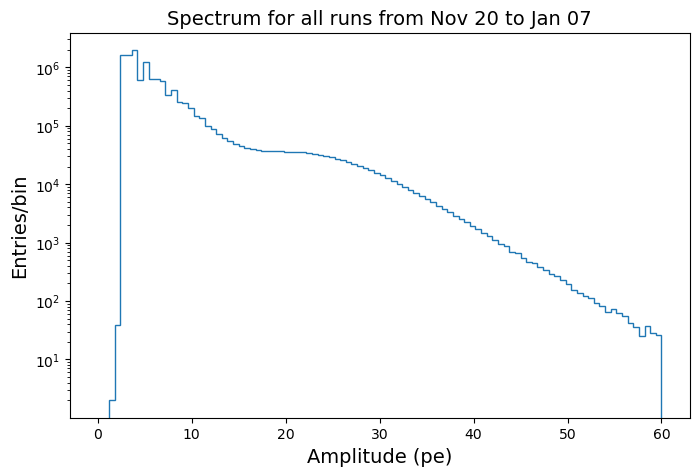

In [17]:
plt.figure(figsize=(8, 5))
plt.hist(sum_3_chs_thr_all_runs, bins=100, range=(0,60), log=True, histtype='step')
plt.title('Spectrum for all runs from Nov 20 to Jan 07', fontsize=14)
plt.xlabel('Amplitude (pe)', fontsize=14)
plt.ylabel('Entries/bin',    fontsize=14)
plt.show()

## Case taking the peaks only from the trigger window

In [18]:
trigger_window = (1370/2, 1750/2)

files        = os.listdir(evts_path)
filt_files   = [file for file in files if file.startswith("BACoN_hits_and_times_thr50_md50_run-")]
sorted_files = sorted(filt_files, key=extract_date_and_number)

height_peaks_deconv_ch_trigg_all_runs_tw = {date: {} for date in np.unique(np.array([extract_date_and_number(filename)[0] for filename in sorted_files]))}

for filename in sorted_files:
    my_file    = evts_path+filename
    d          = np.load(my_file, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    for ch in trigger_chs:
        idx_sel_ch = d['idx_peaks_ch_trigg_dict']          .item()[ch]
        hei_sel_ch = d['height_peaks_deconv_ch_trigg_dict'].item()[ch]
        
        heights_trigger_window = np.array([val[(idx > trigger_window[0]) & (idx < trigger_window[1])] for idx,val in zip(idx_sel_ch, hei_sel_ch)], dtype=object)
        
        if ch not in height_peaks_deconv_ch_trigg_all_runs_tw[date]:
            print(date)
            height_peaks_deconv_ch_trigg_all_runs_tw[date][ch] = np.array([])
            
        height_peaks_deconv_ch_trigg_all_runs_tw[date][ch] = np.concatenate((height_peaks_deconv_ch_trigg_all_runs_tw[date][ch], heights_trigger_window))

01_01_2024
01_01_2024
01_01_2024
01_02_2024
01_02_2024
01_02_2024
01_04_2024
01_04_2024
01_04_2024
01_05_2024
01_05_2024
01_05_2024
01_07_2024
01_07_2024
01_07_2024
01_09_2024
01_09_2024
01_09_2024
01_10_2024
01_10_2024
01_10_2024
01_12_2024
01_12_2024
01_12_2024
01_15_2024
01_15_2024
01_15_2024
11_20_2023
11_20_2023
11_20_2023
11_21_2023
11_21_2023
11_21_2023
11_23_2023
11_23_2023
11_23_2023
11_24_2023
11_24_2023
11_24_2023
11_25_2023
11_25_2023
11_25_2023
11_26_2023
11_26_2023
11_26_2023
11_28_2023
11_28_2023
11_28_2023
11_29_2023
11_29_2023
11_29_2023
11_30_2023
11_30_2023
11_30_2023
12_20_2023
12_20_2023
12_20_2023
12_21_2023
12_21_2023
12_21_2023
12_24_2023
12_24_2023
12_24_2023
12_26_2023
12_26_2023
12_26_2023
12_28_2023
12_28_2023
12_28_2023
12_30_2023
12_30_2023
12_30_2023


In [19]:
sum_peaks_above_thr_all_runs_tw = {}
for i, (_, thr) in enumerate(zip(periods, [70, 300, 400])):
    for sel_date in height_peaks_deconv_ch_trigg_all_runs.keys():
        if sel_date in dates[i]:
            print(sel_date)
            sum_peaks_above_thr_all_runs_tw[sel_date] = {ch: [np.sum(el[np.where(el>thr)[0]]) for el in height_peaks_deconv_ch_trigg_all_runs_tw[sel_date][ch]] for ch in trigger_chs}

11_20_2023
11_21_2023
11_23_2023
11_24_2023
11_25_2023
11_26_2023
11_28_2023
11_29_2023
11_30_2023
01_01_2024
01_02_2024
01_04_2024
01_05_2024
01_07_2024
01_09_2024
01_10_2024
01_12_2024
01_15_2024
12_20_2023
12_21_2023
12_24_2023
12_26_2023
12_28_2023
12_30_2023


In [26]:
sum_3_chs_thr_all_runs_tw_dict = {}
for k, ch in enumerate(trigger_chs):
    sum_3_chs_thr_all_runs_tw_list = []
    for i,per in enumerate(periods):
        for sel_date in sum_peaks_above_thr_all_runs.keys():
            if sel_date in dates[i]:
                sum_3_chs_thr_all_runs_tw_list.append(sum_peaks_above_thr_all_runs_tw[sel_date][ch]/slopes_all_dates_trigger_SiPMs[per][k])
    sum_3_chs_thr_all_runs_tw_dict[k] = np.concatenate(sum_3_chs_thr_all_runs_tw_list)

sum_3_chs_thr_all_runs_tw = np.sum(np.array([vals for vals in sum_3_chs_thr_all_runs_tw_dict.values()]), axis=0)

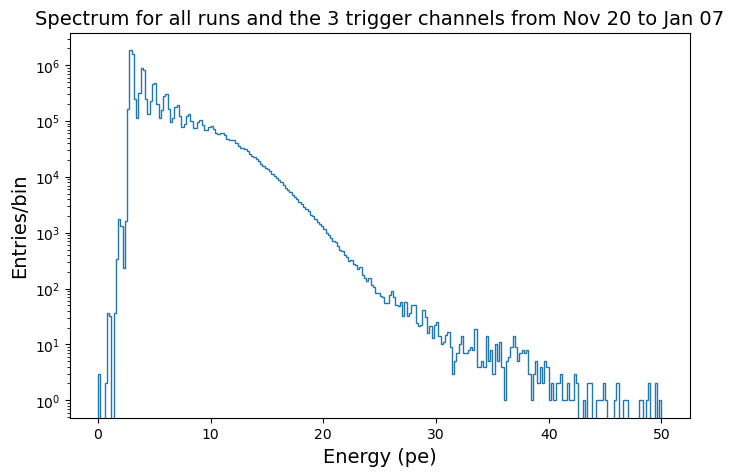

In [32]:
plt.figure(figsize=(8, 5))
plt.hist(sum_3_chs_thr_all_runs_tw, bins=250, range=(0,50), log=True, histtype='step')
plt.title('Spectrum for all runs and the 3 trigger channels from Nov 20 to Jan 07', fontsize=14)
plt.xlabel('Energy (pe)', fontsize=14)
plt.ylabel('Entries/bin',    fontsize=14)
plt.show()

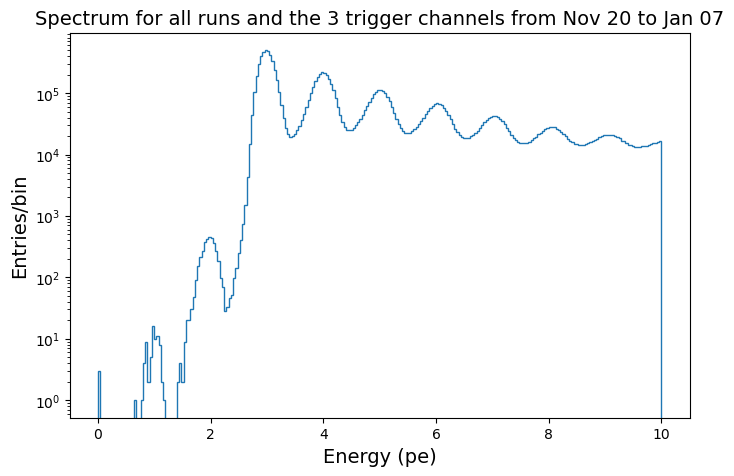

In [28]:
plt.figure(figsize=(8, 5))
plt.hist(sum_3_chs_thr_all_runs_tw, bins=250, range=(0,10), log=True, histtype='step')
plt.title('Spectrum for all runs and the 3 trigger channels from Nov 20 to Jan 07', fontsize=14)
plt.xlabel('Energy (pe)', fontsize=14)
plt.ylabel('Entries/bin',    fontsize=14)
plt.show()

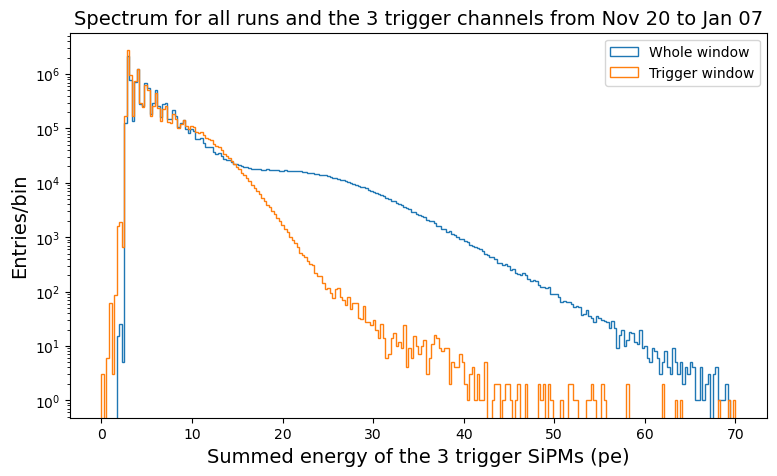

In [34]:
plt.figure(figsize=(9, 5))
plt.hist(sum_3_chs_thr_all_runs,    bins=250, range=(0,70), log=True, histtype='step', label='Whole window')
plt.hist(sum_3_chs_thr_all_runs_tw, bins=250, range=(0,70), log=True, histtype='step', label='Trigger window')
plt.title('Spectrum for all runs and the 3 trigger channels from Nov 20 to Jan 07', fontsize=14)
plt.xlabel('Summed energy of the 3 trigger SiPMs (pe)', fontsize=14)
plt.ylabel('Entries/bin', fontsize=14)
plt.legend()
plt.show()